In [1]:
%matplotlib inline

In [2]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import load_iris
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OrdinalEncoder
from sklvq import GMLVQ


matplotlib.rc("xtick", labelsize="small")
matplotlib.rc("ytick", labelsize="small")
data = np.genfromtxt('fourcl.csv', delimiter=',')
labels = np.genfromtxt('fourcl_labels.csv', delimiter=',')
#feature_names = [name[:-5] for name in iris.feature_names]


# Generalized Matrix LVQ (GMLVQ)

Example of how to use GMLVQ `[1]`_ on the classic iris dataset.


In [3]:
labelpd = pd.read_csv('fourcl_labels.csv',header=None).to_numpy()

In [4]:
np.shape(labelpd)

(4000, 1)

In [5]:
labelpd = labelpd.squeeze()

In [6]:
np.shape(labelpd)

(4000,)

In [7]:
np.shape(data)

(4000, 10)

In [8]:
labels = labelpd

In [9]:
type(labels)

numpy.ndarray

## Fitting the Model
Scale the data and create a GLVQ object with, e.g., custom distance function, activation
function and solver. See the API reference under documentation for defaults and other
possible parameters.



In [10]:
# Sklearn's standardscaler to perform z-transform
scaler = StandardScaler()

# Compute (fit) and apply (transform) z-transform
data = scaler.fit_transform(data)

# The creation of the model object used to fit the data to.
model = GMLVQ(
    distance_type="adaptive-squared-euclidean",
    activation_type="sigmoid",
    activation_params={"beta": 2},
    solver_type="sgd",
    solver_params={"max_runs": 20,"batch_size":1,"step_size": np.array([0.1, 0.05])},
    random_state=1428,
)

In [11]:
data.shape

(4000, 10)

The next step is to fit the GMLVQ object to the data and use the predict method to make the
predictions. Note that this example only works on the training data and therefor does not say
anything about the generalizability of the fitted model.



In [12]:
# Train the model using the scaled data and true labels
model.fit(data, labels)

# Predict the labels using the trained model
# predicting on the same trianing data?
predicted_labels = model.predict(data)
print(len(data))
# To get a sense of the training performance we could print the classification report.
print(classification_report(labels, predicted_labels))

4000
              precision    recall  f1-score   support

          A1       0.69      0.75      0.72      1000
          A2       0.76      0.71      0.74      1000
          B1       0.76      0.69      0.72      1000
          B2       0.70      0.74      0.72      1000

    accuracy                           0.73      4000
   macro avg       0.73      0.73      0.73      4000
weighted avg       0.73      0.73      0.73      4000



In [13]:
feature_names = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j']#, 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z','ab','ac','ad','ae','af','ag','ah','ai','aj','ak']


## Extracting the Relevance Matrix
In addition to the prototypes (see GLVQ example), GMLVQ learns a
matrix `lambda_` which can tell us something about which features are most relevant for the
classification.



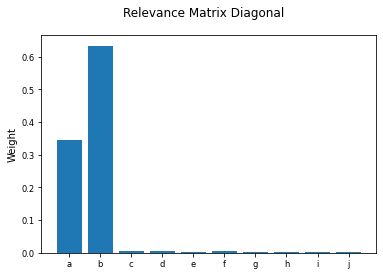

In [14]:
# The relevance matrix is available after fitting the model.
relevance_matrix = model.lambda_

# Plot the diagonal of the relevance matrix
fig, ax = plt.subplots()
fig.suptitle("Relevance Matrix Diagonal")
ax.bar(feature_names, np.diagonal(relevance_matrix))
ax.set_ylabel("Weight")
ax.grid(False)

Note that the relevance diagonal adds up to one. The most relevant features for
distinguishing between the classes present in  the iris dataset seem to be (in decreasing
order) the petal length, petal width, sepal length, and sepal width. Although not very
interesting for the iris dataset one could use this information to select only the top most
relevant features to be used for the classification and thus reducing the dimensionality of
the problem.



## Transforming the data
In addition to making predictions GMLVQ can be used to transform the data using the
eigenvectors of the relevance matrix.



4
['A1' 'A2' 'B1' 'B2']
A1: Black, A2: Red, B1: Green, B2: Blue, Centers A and B, and diseases 1 and 2.) 


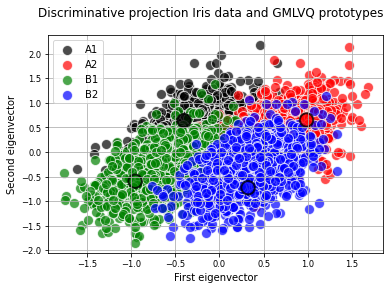

In [15]:
# Transform the data (scaled by square root of eigenvalues "scale = True")
# data is the remaining datapoints.
transformed_data = model.transform(data, scale=True)

x_d = transformed_data[:, 0]
y_d = transformed_data[:, 1]

# Transform the model, i.e., the prototypes (scaled by square root of eigenvalues "scale = True")
# prototypes are the 4 dots
transformed_model = model.transform(model.prototypes_, scale=True)
print(len(model.prototypes_))
x_m = transformed_model[:, 0]
y_m = transformed_model[:, 1]
#prototypes = ['PD','AD','HC']
# Plot
fig, ax = plt.subplots()
fig.suptitle("Discriminative projection Iris data and GMLVQ prototypes")
colors = ["black", "red", "green","blue"]
for i, cls in enumerate(model.classes_):
    ii = cls == labels
    ax.scatter(
        x_d[ii],
        y_d[ii],
        c=colors[i],
        s=100,
        alpha=0.7,
        edgecolors="white",
        label=model.classes_[model.prototypes_labels_[i]],
    )
ax.scatter(x_m, y_m, c=colors, s=180, alpha=0.8, edgecolors="black", linewidth=2.0)
ax.set_xlabel("First eigenvector")
ax.set_ylabel("Second eigenvector")
ax.legend()
ax.grid(True)
print(model.classes_)
#plt.savefig('destination_path1.eps', format='eps')
print('A1: Black, A2: Red, B1: Green, B2: Blue, Centers A and B, and diseases 1 and 2.) ')

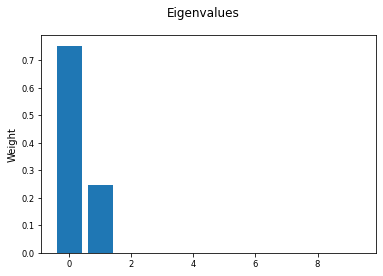

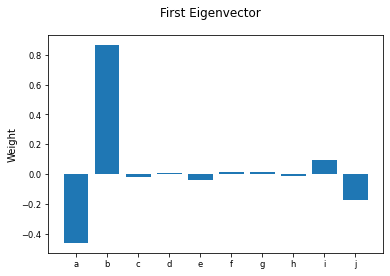

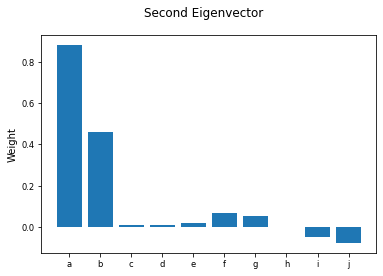

In [16]:
# Plot the eigenvalues of the eigenvectors of the relevance matrix.
fig, ax = plt.subplots()
fig.suptitle("Eigenvalues")
ax.bar(range(0, len(model.eigenvalues_)), model.eigenvalues_)
ax.set_ylabel("Weight")
ax.grid(False)

# Plot the first two eigenvectors of the relevance matrix, which  is called `omega_hat`.
fig, ax = plt.subplots()
fig.suptitle("First Eigenvector")
ax.bar(feature_names, model.omega_hat_[:, 0])
ax.set_ylabel("Weight")
ax.grid(False)

fig, ax = plt.subplots()
fig.suptitle("Second Eigenvector")
ax.bar(feature_names, model.omega_hat_[:, 1])
ax.set_ylabel("Weight")
ax.grid(False)

In [17]:
labels

array(['A1', 'A1', 'A1', ..., 'B2', 'B2', 'B2'], dtype=object)

In [18]:
#print(np.where((labels == 'A1') & (labels == 'A2')))# and np.where(labels == 'A2')        
labelssubclass = labels
labelssubclass = np.where(labels == 'A1','A',labelssubclass) 
labelssubclass = np.where(labels == 'A2','A',labelssubclass) 
labelssubclass = np.where(labels == 'B1','B',labelssubclass) 
labelssubclass = np.where(labels == 'B2','B',labelssubclass) 


In [19]:
labelssubclass

array(['A', 'A', 'A', ..., 'B', 'B', 'B'], dtype=object)

In [20]:
labelssubclass.shape

(4000,)

In [21]:
labels1 = np.where(labels == 'A1') 
labels2 = np.where(labels == 'A2') 
labels3 = np.where(labels == 'B1') 
labels4 = np.where(labels == 'B2') 

In [22]:
#labelssubclass[labels1] = 'A1'
#labelssubclass[labels2] = 'A2'
#labelssubclass[labels3] = 'B1'
#labelssubclass[labels4] = 'B2'

In [23]:
labelssubclass[3999
              ]

'B'

In [24]:
data.shape

(4000, 10)

In [25]:
# Train the model using the scaled data and true labels
model.fit(data, labelssubclass)

# Predict the labels using the trained model
# predicting on the same trianing data?
predicted_labels = model.predict(data)
# To get a sense of the training performance we could print the classification report.
print(classification_report(labelssubclass, predicted_labels))

              precision    recall  f1-score   support

           A       0.78      0.77      0.78      2000
           B       0.77      0.79      0.78      2000

    accuracy                           0.78      4000
   macro avg       0.78      0.78      0.78      4000
weighted avg       0.78      0.78      0.78      4000



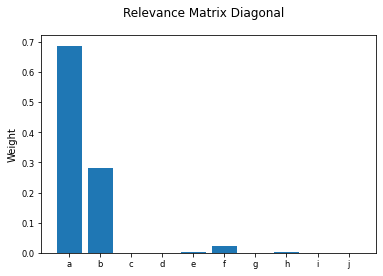

In [26]:
# The relevance matrix is available after fitting the model.
relevance_matrix1 = model.lambda_

# Plot the diagonal of the relevance matrix
fig, ax = plt.subplots()
fig.suptitle("Relevance Matrix Diagonal")
ax.bar(feature_names, np.diagonal(relevance_matrix1))
ax.set_ylabel("Weight")
ax.grid(False)

2


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

['A' 'B']
A1: Black, A2: Red, B1: Green, B2: Blue, Centers A and B, and diseases 1 and 2.) 


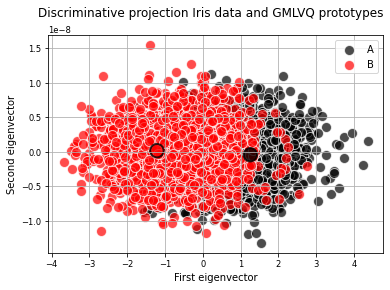

In [27]:

transformed_data = model.transform(data, scale=True)

x_d = transformed_data[:, 0]
y_d = transformed_data[:, 1]

transformed_model = model.transform(model.prototypes_, scale=True)
print(len(model.prototypes_))
x_m = transformed_model[:, 0]
y_m = transformed_model[:, 1]

fig, ax = plt.subplots()
fig.suptitle("Discriminative projection Iris data and GMLVQ prototypes")
colors = ["black", "red"]#, "green","blue"]
for i, cls in enumerate(model.classes_):
    ii = cls == labelssubclass
    ax.scatter(
        x_d[ii],
        y_d[ii],
        c=colors[i],
        s=100,
        alpha=0.7,
        edgecolors="white",
        label=model.classes_[model.prototypes_labels_[i]],
    )
ax.scatter(x_m, y_m, c=colors, s=180, alpha=0.8, edgecolors="black", linewidth=2.0)
ax.set_xlabel("First eigenvector")
ax.set_ylabel("Second eigenvector")
ax.legend()
ax.grid(True)
print(model.classes_)
plt.savefig('destination_path23.eps', format='eps')
print('A1: Black, A2: Red, B1: Green, B2: Blue, Centers A and B, and diseases 1 and 2.) ')

In [28]:
#print(np.where((labels == 'A1') & (labels == 'A2')))# and np.where(labels == 'A2')              

The transformed data and prototypes can be used to visualize the problem in a lower dimension,
which is also the space the model would compute the distance. The axis are the directions which
are the most discriminating directions (combinations of features). Hence, inspecting the
eigenvalues and eigenvectors (axis) themselves can be interesting.



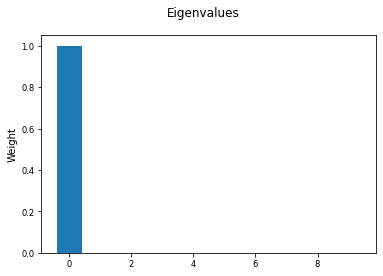

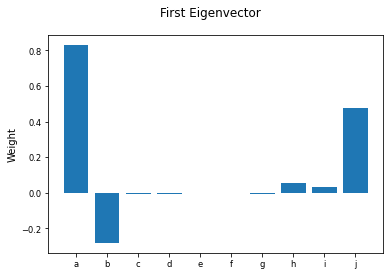

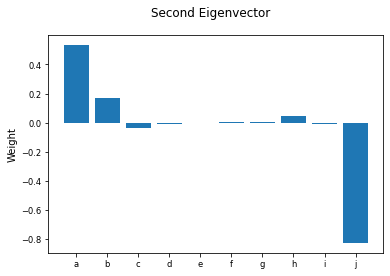

In [29]:
# Plot the eigenvalues of the eigenvectors of the relevance matrix.
fig, ax = plt.subplots()
fig.suptitle("Eigenvalues")
ax.bar(range(0, len(model.eigenvalues_)), model.eigenvalues_)
ax.set_ylabel("Weight")
ax.grid(False)

# Plot the first two eigenvectors of the relevance matrix, which  is called `omega_hat`.
fig, ax = plt.subplots()
fig.suptitle("First Eigenvector")
ax.bar(feature_names, model.omega_hat_[:, 0])
ax.set_ylabel("Weight")
ax.grid(False)

fig, ax = plt.subplots()
fig.suptitle("Second Eigenvector")
ax.bar(feature_names, model.omega_hat_[:, 1])
ax.set_ylabel("Weight")
ax.grid(False)

In [30]:
model.eigenvalues_

# the eigenvectors are column vectors.
# so should that be transpose in non transpose

array([ 1.00000000e+00,  1.40525077e-17,  2.46126087e-19,  9.25429564e-20,
        5.98967564e-21,  7.01368612e-22, -8.61113658e-20, -5.35537600e-19,
       -2.21052579e-18, -8.06583282e-17])

In [31]:
#model.omega_hat_

In [32]:
# the eigen values themselves are pretty small
model.eigenvalues_

array([ 1.00000000e+00,  1.40525077e-17,  2.46126087e-19,  9.25429564e-20,
        5.98967564e-21,  7.01368612e-22, -8.61113658e-20, -5.35537600e-19,
       -2.21052579e-18, -8.06583282e-17])

In [33]:
# verified and checked the dimensions
square = np.sqrt(model.eigenvalues_)
omegatranspose = np.zeros((10,10))
for i in range(len(square)):
    #print(square[i])
    #print(model.omega_hat_[i,:])
    omegatranspose[:,i] = (square[i]*model.omega_hat_[:,i])

# replacing the nan values with 0, a perfect column matrix
omegatranspose = np.nan_to_num(omegatranspose) 

<ipython-input-33-30df07399845>:2: RuntimeWarning: invalid value encountered in sqrt
  square = np.sqrt(model.eigenvalues_)


In [34]:
#omegatranspose

In [35]:
I = np.identity(10)

In [36]:
model.omega_hat_

array([[ 8.29417879e-01,  5.31724904e-01, -1.10344555e-02,
         7.32808592e-03,  6.23006431e-02,  1.48935878e-01,
        -2.09925365e-02, -4.53734391e-02, -8.67488456e-04,
         2.44068331e-02],
       [-2.81145155e-01,  1.71399421e-01, -5.73106574e-02,
         2.54161075e-02,  5.28434973e-01,  7.38402464e-01,
        -1.55885171e-01,  1.66036330e-01, -5.72000371e-03,
         1.06143596e-01],
       [-4.24484749e-03, -3.39427990e-02, -3.51234508e-01,
        -5.65375844e-02,  9.77245949e-02,  1.79448775e-01,
         4.76088905e-01, -2.84886754e-01, -6.66424786e-03,
        -7.22945509e-01],
       [-7.52356541e-03, -1.13294472e-02, -7.91591233e-01,
         2.70281899e-01, -7.71324865e-02, -9.24393588e-02,
        -5.00086857e-01, -1.74037947e-01, -1.90765095e-02,
         7.00829061e-02],
       [-2.46053863e-03, -3.91769513e-04, -2.33352686e-01,
        -9.54745587e-01, -2.17369015e-02, -3.16882581e-05,
        -1.05900429e-01, -5.48630637e-02,  2.44017469e-02,
         1.

In [37]:
v0 = model.omega_hat_[:,0]

In [38]:
v0t = np.transpose(v0)

In [39]:
v0.shape


(10,)

In [40]:
l1 = np.outer(v0,v0t)

In [41]:
np.shape(l1)

(10, 10)

In [42]:
v01 = model.omega_hat_[:,1]

In [43]:
v01t = np.transpose(v01)

In [44]:
l2 = np.outer(v01,v01t)

In [45]:
l1+l2

array([[ 9.70665393e-01, -1.42049478e-01, -2.15689840e-02,
        -1.22643289e-02, -2.24912834e-03,  1.91613324e-03,
        -4.70688028e-03,  7.22950531e-02,  2.33583879e-02,
        -4.33281132e-02],
       [-1.42049478e-01,  1.08420360e-01, -4.62435778e-03,
         1.73353277e-04,  6.24619448e-04, -2.44841714e-04,
         2.01731585e-03, -7.40675634e-03, -1.20687182e-02,
        -2.76153730e-01],
       [-2.15689840e-02, -4.62435778e-03,  1.17013234e-03,
         4.16489538e-04,  2.37423651e-05, -4.57362670e-05,
        -1.33655965e-05, -1.88819003e-03,  2.49018602e-04,
         2.60452261e-02],
       [-1.22643289e-02,  1.73353277e-04,  4.16489538e-04,
         1.84960411e-04,  2.29505554e-05, -2.48684243e-05,
         3.48904638e-05, -9.72156306e-04, -1.35076878e-04,
         5.77435935e-03],
       [-2.24912834e-03,  6.24619448e-04,  2.37423651e-05,
         2.29505554e-05,  6.20773370e-06, -4.31993835e-06,
         1.53857064e-05, -1.56815960e-04, -8.32908591e-05,
        -8.

In [46]:
I-(l1+l2)

array([[ 2.93346075e-02,  1.42049478e-01,  2.15689840e-02,
         1.22643289e-02,  2.24912834e-03, -1.91613324e-03,
         4.70688028e-03, -7.22950531e-02, -2.33583879e-02,
         4.33281132e-02],
       [ 1.42049478e-01,  8.91579640e-01,  4.62435778e-03,
        -1.73353277e-04, -6.24619448e-04,  2.44841714e-04,
        -2.01731585e-03,  7.40675634e-03,  1.20687182e-02,
         2.76153730e-01],
       [ 2.15689840e-02,  4.62435778e-03,  9.98829868e-01,
        -4.16489538e-04, -2.37423651e-05,  4.57362670e-05,
         1.33655965e-05,  1.88819003e-03, -2.49018602e-04,
        -2.60452261e-02],
       [ 1.22643289e-02, -1.73353277e-04, -4.16489538e-04,
         9.99815040e-01, -2.29505554e-05,  2.48684243e-05,
        -3.48904638e-05,  9.72156306e-04,  1.35076878e-04,
        -5.77435935e-03],
       [ 2.24912834e-03, -6.24619448e-04, -2.37423651e-05,
        -2.29505554e-05,  9.99993792e-01,  4.31993835e-06,
        -1.53857064e-05,  1.56815960e-04,  8.32908591e-05,
         8.

In [47]:
# checked and correct!
N=10
sum1 = np.zeros((N,N))
a1 = np.zeros((N,N))
K=2
for i in range(K):
        # column times rows
        a1 = np.outer(model.omega_hat_[:,i],model.omega_hat_[:,i].transpose())
        sum1 = sum1 + a1
        print(sum1)
print(np.shape(sum1))

[[ 6.87934019e-01 -2.33186819e-01 -3.52075240e-03 -6.24017967e-03
  -2.04081473e-03  1.30422332e-03 -5.34476219e-03  4.64391087e-02
   2.96352947e-02  3.96464504e-01]
 [-2.33186819e-01  7.90425984e-02  1.19341831e-03  2.11521397e-03
   6.91768515e-04 -4.42088455e-04  1.81169714e-03 -1.57413178e-02
  -1.00453821e-02 -1.34388319e-01]
 [-3.52075240e-03  1.19341831e-03  1.80187302e-05  3.19363878e-05
   1.04446112e-05 -6.67483694e-06  2.73537633e-05 -2.37669019e-04
  -1.51669393e-04 -2.02905121e-03]
 [-6.24017967e-03  2.11521397e-03  3.19363878e-05  5.66040365e-05
   1.85120233e-05 -1.18304774e-05  4.84817955e-05 -4.21244442e-04
  -2.68818751e-04 -3.59628928e-03]
 [-2.04081473e-03  6.91768515e-04  1.04446112e-05  1.85120233e-05
   6.05425035e-06 -3.86908933e-06  1.58556913e-05 -1.37765563e-04
  -8.79156203e-05 -1.17614565e-03]
 [ 1.30422332e-03 -4.42088455e-04 -6.67483694e-06 -1.18304774e-05
  -3.86908933e-06  2.47261864e-06 -1.01328955e-05  8.80418282e-05
   5.61842291e-05  7.51639313e-04

In [48]:
omega_new_hat = np.matmul(model.omega_hat_,(I-sum1))

In [49]:
#omega_new_hat

In [50]:
# column vectors
omega_new_hat.shape

(10, 10)

In [56]:
# normalized omega new hat 
for i in range(len(omega_new_hat)):
    #print(i)
    #print(np.sqrt(np.sum(np.square(omega_new_hat[:,i]))))
    omega_new_hat[:,i]=omega_new_hat[:,i] / np.sqrt(np.sum(np.square(omega_new_hat[:,i])))
print(omega_new_hat[:,0])
print((omega_new_hat[:,0])/2)

[ 0.60621021  0.04054573 -0.12652688 -0.0109474  -0.04726307 -0.15378402
  0.08960573 -0.42735184  0.08227718 -0.62563942]
[ 0.30310511  0.02027286 -0.06326344 -0.0054737  -0.02363154 -0.07689201
  0.04480286 -0.21367592  0.04113859 -0.31281971]


In [66]:
print(np.sum(np.square(omega_new_hat[:,9])))

1.0


In the plots from the eigenvalues and eigenvector we see a similar effects as we could see from
just the diagonal of `lambda_`. The two leading (most relevant or discriminating) eigenvectors
mostly use the petal length and petal width in their calculation. The diagonal of the
relevance matrix can therefor be considered as a summary of the relevances of the features.



## References
_`[1]` Schneider, P., Biehl, M., & Hammer, B. (2009). "Adaptive Relevance Matrices in Learning
Vector Quantization" Neural Computation, 21(12), 3532–3561, 2009.

